# <font color = 'red'>Deep Learning - TEST</font>
<br>

# 이름 :  전승우

# 사전 학습된 CNN(ResNet)을 이용한 "Wafer Image" Fine Tunig
## ResNet Model
* ILSVRC-2015 우승
* Residual Network(Skip Connection)
* 152 Layers

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Keras

* Keras Version 확인

In [2]:
import keras

keras.__version__

'2.4.3'

# I. Google Drive Mount
* 'dogs_and_cats_small.zip' 디렉토리를 구글드라이브에 업로드

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


> ## 1) 구글 드라이브 마운트 결과 확인

In [4]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/waferImages.zip'

-rw------- 1 root root 1141460846 Mar  4 04:50 '/content/drive/My Drive/Colab Notebooks/datasets/waferImages.zip'


> ## 2) unzip 'waferImages.zip'

* 약2분

In [5]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/waferImages.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: waferimages/waferimages/training/none/753521.png  
  inflating: waferimages/waferimages/training/none/753522.png  
  inflating: waferimages/waferimages/training/none/753523.png  
  inflating: waferimages/waferimages/training/none/753524.png  
  inflating: waferimages/waferimages/training/none/753525.png  
  inflating: waferimages/waferimages/training/none/753526.png  
  inflating: waferimages/waferimages/training/none/753527.png  
  inflating: waferimages/waferimages/training/none/753528.png  
  inflating: waferimages/waferimages/training/none/753529.png  
  inflating: waferimages/waferimages/training/none/753530.png  
  inflating: waferimages/waferimages/training/none/753531.png  
  inflating: waferimages/waferimages/training/none/753532.png  
  inflating: waferimages/waferimages/training/none/753533.png  
  inflating: waferimages/waferimages/training/none/753534.png  
  inflating: waferimages/waferimages/training/none/753535.png  
  in

In [6]:
!ls -l waferimages/waferimages

total 12
-rw-r--r--  1 root root  645 Jul  5  2020 Script_To_Generate_Images.py
drwxr-xr-x 11 root root 4096 Apr  2 06:37 testing
drwxr-xr-x 11 root root 4096 Apr  2 06:37 training


In [7]:
!ls -dir waferimages/waferimages

2245011 waferimages/waferimages


> ## 3) Wafer Images

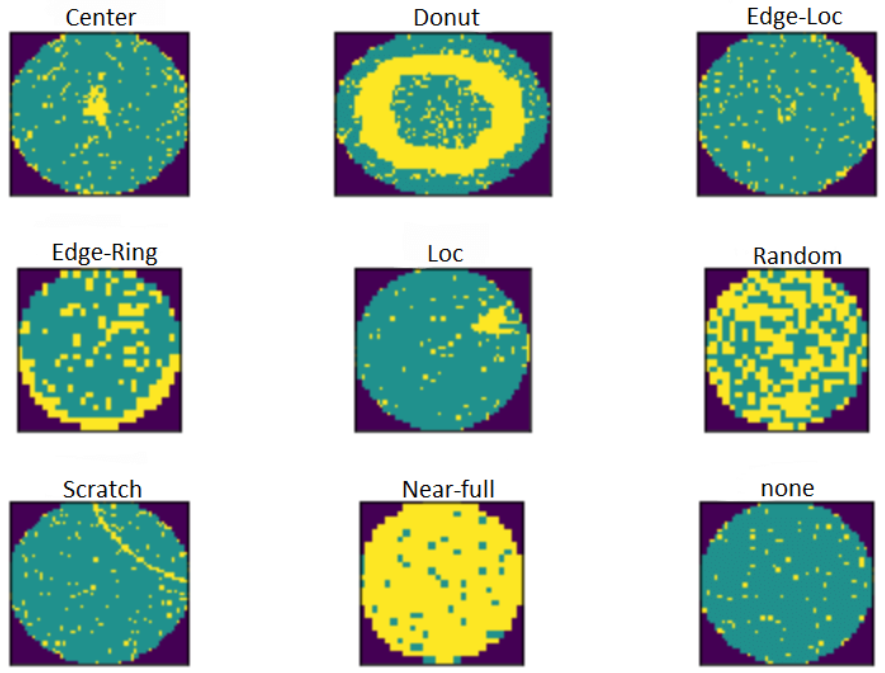

# II. from keras.applications import ResNet50

* ResNet50 사용 - Fine Tuning 진행

In [8]:
#freeze
#재구성
#204 cnn finetune 다중분류

In [9]:
train_dir = 'waferimages/waferimages/training'
valid_dir = 'waferimages/waferimages/testing'
test_dir = 'waferimages/waferimages/testing'

> ## 1) conv_base

In [38]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (75, 75),
                  batch_size = 9,
                  class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (75, 75),
                  batch_size = 9,
                  class_mode = 'categorical')

Found 54374 images belonging to 9 classes.
Found 118595 images belonging to 9 classes.


In [39]:
for data_batch, labels_batch in train_generator:
  print('배치 데이터 크기:', data_batch.shape)
  print('배치 레이블 크기:', labels_batch.shape)
  break

배치 데이터 크기: (9, 75, 75, 3)
배치 레이블 크기: (9, 9)


In [40]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import numpy as np

conv_base = ResNet50(weights = 'imagenet',
                  include_top =False,
                  input_shape = (75, 75, 3))


> ## 2) Model Information

In [41]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

> ## 3) Freezing

In [42]:
print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 212


In [43]:
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv5_block1_1_conv':
    set_trainable = True
  
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [44]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))


conv_base 동결 후 훈련 가능 가중치의 종류: 40


# III. Keras CNN Modeling with ResNet50 Freezed Layers


> ## 1) Model Define

In [45]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (75, 75, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(9, activation = 'softmax'))

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 512)        

> ## 2) Model Compile

In [47]:
# 모델 학습방법 설정
from keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit

In [48]:
%%time
Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 5s 46ms/step - loss: 2.0866 - accuracy: 0.4966 - val_loss: 1.6467 - val_accuracy: 0.9267
Epoch 2/100
100/100 [==============================] - 4s 44ms/step - loss: 1.6608 - accuracy: 0.6673 - val_loss: 0.8720 - val_accuracy: 0.9556
Epoch 3/100
100/100 [==============================] - 5s 46ms/step - loss: 1.2325 - accuracy: 0.6855 - val_loss: 0.6421 - val_accuracy: 0.9467
Epoch 4/100
100/100 [==============================] - 5s 45ms/step - loss: 1.1653 - accuracy: 0.6822 - val_loss: 0.5853 - val_accuracy: 0.9511
Epoch 5/100
100/100 [==============================] - 5s 46ms/step - loss: 1.1690 - accuracy: 0.6771 - val_loss: 0.6409 - val_accuracy: 0.9200
Epoch 6/100
100/100 [==============================] - 4s 44ms/step - loss: 1.1575 - accuracy: 0.6645 - val_loss: 0.6236 - val_accuracy: 0.9356
Epoch 7/100
100/100 [==============================] - 4s 45ms/step - loss: 1.0221 - accuracy: 0.7009 - val_loss: 0.7025 - val_accuracy:

> ## 4) 학습 결과 시각화

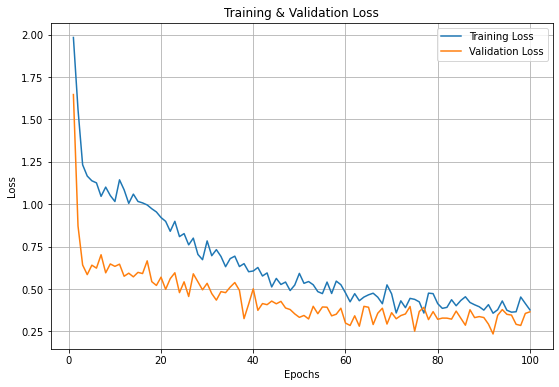

In [50]:
# Loss Visualization
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)
plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

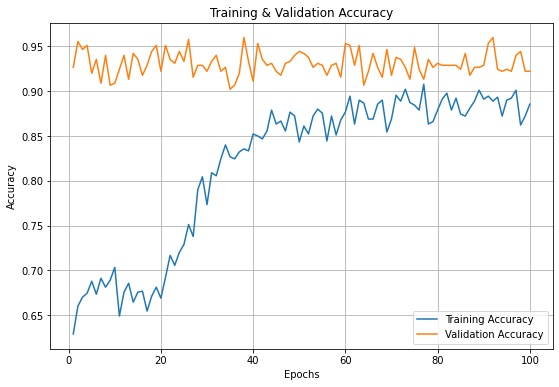

In [51]:
# Accuracy Visualization
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

In [52]:
# test_generator
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (75, 75),
    batch_size = 9,
    class_mode = 'categorical')

Found 118595 images belonging to 9 classes.


In [56]:
# Loss & Accuracy
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 1s 29ms/step - loss: 0.3686 - accuracy: 0.9200
Loss = 0.36857
Accuracy = 0.92000


# IV. Model Save & Load to Google Drive

> ## 1) Google Drive Mount

In [57]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ## 2) Model Save

In [59]:
model.save('/content/drive/My Drive/Colab Notebooks/models/wafer_fine_tuning.h5')

!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 415994
-rw------- 1 root root     34592 Mar 17 07:36 001_Model_iris.h5
-rw------- 1 root root  20909728 Apr  2 06:53 002_dogs_and_cats_small.h5
-rw------- 1 root root  41499744 Mar 23 06:39 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 140748416 Mar 24 07:28 004_dogs_and_cats_feature_extraction.h5
-rw------- 1 root root 201873880 Mar 24 08:37 006_dogs_and_cats_VGG16.h5
-rw------- 1 root root  20909728 Apr  2 06:53 wafer_fine_tuning.h5


> ## 3) Model Load

In [60]:
from keras.models import load_model

model_small = load_model('/content/drive/My Drive/Colab Notebooks/models/wafer_fine_tuning.h5')

loss, accuracy = model_small.evaluate(test_generator,
                                      steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 2s 30ms/step - loss: 0.2907 - accuracy: 0.9489
Loss = 0.29066
Accuracy = 0.94889
